In [ ]:
# TCGA_color_clouds_03
# Apply MNIST image gen example to TCGA data
# Goal is to generate synthetic gene expression subtype samples
# From:
    # TCGA color clouds v2
    # https://becominghuman.ai/using-variational-autoencoder-vae-to-generate-new-images-14328877e88d

In [209]:
pwd # Send to image_gen folder in root VAE- dir when done

'/Users/karlberb/work/sample_count/smpl_gen/image_gen'

In [1]:
%whos # want this level of interactivity in main app

No variables match your requested type.


In [ ]:
# Restart kernel from v2

In [2]:
# TCGA data formatting
import glob as glob
import pandas as pd
import matplotlib.pyplot as pyplot

In [211]:
ls ../gexp_files/ # 26 cancers cut to just gene expression

ACC_gxp.tsv       HNSC_gxp.tsv      MESO_gxp.tsv      TGCT_gxp.tsv
BLCA_gxp.tsv      KIRCKICH_gxp.tsv  OV_gxp.tsv        THCA_gxp.tsv
BRCA_gxp.tsv      KIRP_gxp.tsv      PAAD_gxp.tsv      THYM_gxp.tsv
CESC_gxp.tsv      LGGGBM_gxp.tsv    PCPG_gxp.tsv      UCEC_gxp.tsv
COADREAD_gxp.tsv  LIHCCHOL_gxp.tsv  PRAD_gxp.tsv      UVM_gxp.tsv
ESCC_gxp.tsv      LUAD_gxp.tsv      SARC_gxp.tsv
GEA_gxp.tsv       LUSC_gxp.tsv      SKCM_gxp.tsv


In [3]:
import numpy as np

In [4]:
# Process ACC file into 76 square arrays of channel 1
# ---> array with shape (76,144,144,1)

gxp_files = sorted(glob.glob('../gexp_files/*.tsv'))
for i in gxp_files:
    
    file  = pd.read_csv(i,         # <--- read cancer file n
                       sep = '\t',
                       index_col = 0)
    
    empty = []
    
    # empty = np.empty(shape = (76,144,144,1), dtype=np.uint8) # empty preshaped array to fill
    for j, sample in enumerate(file.index):
        gene_row = list(file.iloc[j,1:])
        base = np.array(gene_row + (
            20736 - len(
                gene_row)) * [0], dtype=np.uint8).reshape(144,144,1)
        
        # empty = np.append(empty, base)
        
        empty.append(base)
        
    break # stop after first cancer, adrenocortical carcinoma

In [5]:
np.array(empty).shape # Object set to match structure of MNIST data in example

(76, 144, 144, 1)

In [6]:
acc_formatted = np.array(empty)

In [ ]:
acc_formatted[0] # The data is now integers 0-255, no longer float, why? dtype np.uint8 coersion?

In [8]:
acc_formatted = np.array(empty)   # convert list to array
acc_formatted = acc_formatted/255 # normalize

In [9]:
acc_formatted.shape

(76, 144, 144, 1)

In [5]:
from sklearn.model_selection import train_test_split

In [11]:
xr,xs = train_test_split(acc_formatted)

In [13]:
len(train_test_split(acc_formatted)[0]) # ACC training set

57

In [144]:
len(train_test_split(acc_formatted)[1]) # ACC test set

19

In [14]:
xr.shape # corresponds to index of y list, path to complete color cloud plot

(57, 144, 144, 1)

In [15]:
X_train_new = xr # Replace example data with real data, to main

In [16]:
X_test_new = xs # To vae.fit()

In [6]:
acc_formatted = np.array(empty)       # Optimization short cut, implement later
acc_formatted = acc_formatted/255
X_train_new, X_test_new = train_test_split(acc_formatted)

In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf

In [7]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf; tf.compat.v1.disable_eager_execution()
from keras import backend as K
from keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Flatten, Lambda, Reshape
from keras.models import Model
from keras.losses import binary_crossentropy
from keras.datasets import mnist
np.random.seed(25)
tf.executing_eagerly()

def compute_latent(x):
    batch = K.shape(mu)[0]
    dim = K.int_shape(mu)[1]
    eps = K.random_normal(shape=(batch,dim))
    return mu + K.exp(sigma/2)*eps

def kl_reconstruction_loss(true, pred):
    reconstruction_loss = binary_crossentropy(K.flatten(true), K.flatten(pred)) * img_width * img_height
    kl_loss = 1 + sigma - K.square(mu) - K.exp(sigma) # where does sigma come from?
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    return K.mean(reconstruction_loss + kl_loss)

# (X_train, y_train), (X_test, y_test) = mnist.load_data()
# X_train = X_train/255                                      # Normalizing train and test independently?
# X_test = X_test/255
# X_train_new = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
# X_test_new = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

img_height   = X_train_new.shape[1]
img_width    = X_train_new.shape[2]
num_channels = X_train_new.shape[3]
input_shape =  (img_height, img_width, num_channels)
latent_dim = 2

encoder_input = Input(shape=input_shape)
encoder_conv = Conv2D(filters=8, kernel_size=3, strides=2, 
                padding='same', activation='relu')(encoder_input)
encoder_conv = Conv2D(filters=16, kernel_size=3, strides=2,
                padding='same', activation='relu')(encoder_input)
encoder = Flatten()(encoder_conv)
mu = Dense(latent_dim)(encoder)
sigma = Dense(latent_dim)(encoder)
    
                                                            # 2 args to compute lambda
latent_space = Lambda(compute_latent, output_shape=(latent_dim,))([mu, sigma])
                # call function, portability, mask - attention layer
                    
conv_shape = K.int_shape(encoder_conv)
decoder_input = Input(shape=(latent_dim,))
decoder = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(decoder_input)
decoder = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(decoder)
decoder_conv = Conv2DTranspose(filters=16, kernel_size=3, strides=2, 
                           padding='same', activation='relu')(decoder)
decoder_conv = Conv2DTranspose(filters=8, kernel_size=3, strides=2, 
                           padding='same', activation='relu')(decoder)
decoder_conv =  Conv2DTranspose(filters=num_channels, kernel_size=3, 
                          padding='same', activation='sigmoid')(decoder_conv)
encoder = Model(encoder_input, latent_space)
decoder = Model(decoder_input, decoder_conv)
vae = Model(encoder_input, decoder(encoder(encoder_input)))
vae.compile(optimizer='adam', loss=kl_reconstruction_loss)

Train on 57 samples, validate on 19 samples
Epoch 1/100


2022-08-11 09:16:31.533871: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-11 09:16:31.561292: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


57/57 [==============================] - 1s 10ms/sample - loss: 14396.6092 - val_loss: 14365.6777
Epoch 2/100


/Users/karlberb/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


57/57 [==============================] - 0s 5ms/sample - loss: 14358.8987 - val_loss: 14336.4307
Epoch 3/100
57/57 [==============================] - 0s 5ms/sample - loss: 14329.6877 - val_loss: 14289.2715
Epoch 4/100
57/57 [==============================] - 0s 5ms/sample - loss: 14279.9502 - val_loss: 14232.8730
Epoch 5/100
57/57 [==============================] - 0s 5ms/sample - loss: 14221.1914 - val_loss: 14153.3623
Epoch 6/100
57/57 [==============================] - 0s 5ms/sample - loss: 14134.6476 - val_loss: 14032.2930
Epoch 7/100
57/57 [==============================] - 0s 5ms/sample - loss: 14005.4096 - val_loss: 13862.1318
Epoch 8/100
57/57 [==============================] - 0s 8ms/sample - loss: 13836.2107 - val_loss: 13647.4971
Epoch 9/100
57/57 [==============================] - 0s 7ms/sample - loss: 13628.2584 - val_loss: 13413.3164
Epoch 10/100
57/57 [==============================] - 0s 8ms/sample - loss: 13396.2758 - val_loss: 13152.7227
Epoch 11/100
57/57 [==========

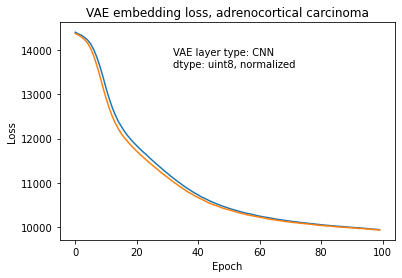

In [8]:
# ACC run on recompiled model, v3, recompiled
history = vae.fit(x=X_train_new, y=X_train_new, epochs=100,
                                                  # Here is the validation data
                  batch_size=32, validation_data=(X_test_new,X_test_new))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('VAE embedding loss, adrenocortical carcinoma')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.annotate('VAE layer type: CNN\ndtype: uint8, normalized',
            xy=(.4, .8), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            # fontsize=20
            )
plt.savefig('TCGA_VAE_out/acc_100_epochs_2022-08-11.png')

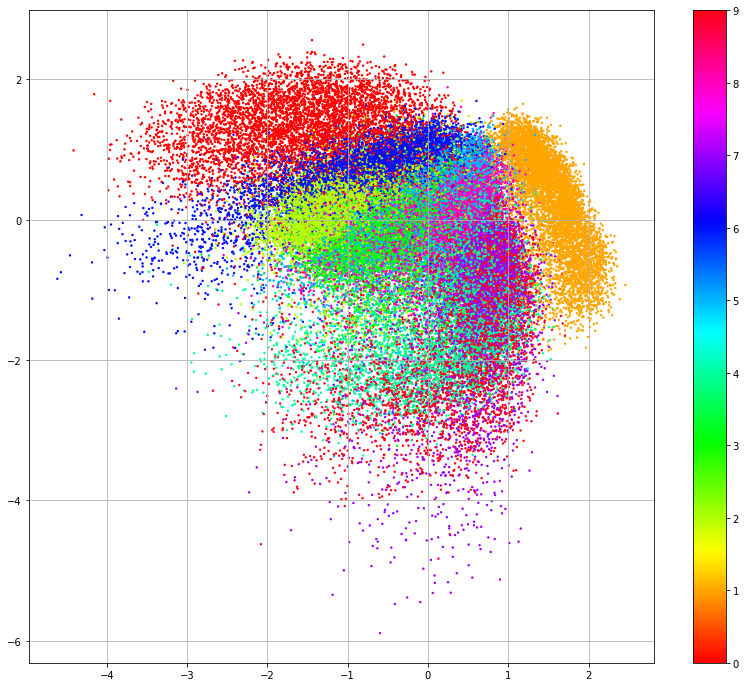

In [179]:
# MNIST run on blank model, want this for TCGA cancers
# number of colors should correspond to the number of subtypes within each cancer
encoded = encoder.predict(X_train_new)

plt.figure(figsize=(14,12))

plt.scatter(encoded[:,0], encoded[:,1], s=2, c=y_train, cmap='hsv')
plt.colorbar()
plt.grid()
plt.show()

In [ ]:
# Next: new sample generation, reverse engineer for TCGA samples

In [ ]:
def display_image_sequence(x_start, y_start, x_end, y_end, no_of_imgs):
    x_axis = np.linspace(x_start,x_end,no_of_imgs) # look at x_axis
    y_axis = np.linspace(y_start,y_end,no_of_imgs)
    x_axis = x_axis[:, np.newaxis]
    y_axis = y_axis[:, np.newaxis]
    new_points = np.hstack((x_axis, y_axis))
    new_images = decoder.predict(new_points)
    new_images = new_images.reshape(new_images.shape[0], new_images.shape[1], new_images.shape[2])
    fig, axes = plt.subplots(ncols=no_of_imgs, sharex=False,
                             sharey=True, figsize=(20, 7))
    counter = 0
    for i in range(no_of_imgs):
        axes[counter].imshow(new_images[i], cmap='gray')
        axes[counter].get_xaxis().set_visible(False)
        axes[counter].get_yaxis().set_visible(False)
        counter += 1
    plt.show()